## Finilizing Data Generation for 0D Reactor

In [1]:
### Importing Libraries

import sys
print(sys.version)
import os
import numpy as np
import pandas as pd
import time

import matplotlib.pyplot as plt
WORKSPACE_PATH  = os.environ['WORKSPACE_PATH']
plt.style.use(WORKSPACE_PATH+'/ROMNet/romnet/extra/postprocessing/presentation.mplstyle')

from scipy.integrate import solve_ivp

pd.options.mode.chained_assignment = None  # default='warn'

from PCAfold import PCA as PCAA

3.8.11 (default, Jun 29 2021, 03:17:05) 
[Clang 12.0.0 (clang-1200.0.32.29)]


In [2]:
### Input Data

OutputDir  = WORKSPACE_PATH+'/ROMNet/Data/0DReact_Isobaric_100Cases_POD/'
# TestDir    = WORKSPACE_PATH+'/ROMNet/Data/0DReact_Isobaric_100Cases_Test/'
try:
    os.makedirs(OutputDir)
except OSError as e:
    pass
# try:
#     os.makedirs(TestDir)
# except OSError as e:
#     pass

NVarsRed           = 7

tStratch           = 1.
SOLVER             = 'BDF'

ValidPerc          = 20.

FixedMinVal        = 1.e-14

POD_NAME           = 'All'
iPC                = 6

In [3]:
FileName     = OutputDir + '/Orig/train/ext/SimIdxs.csv'
Data         = pd.read_csv(FileName, header=0)
SimIdxs      = Data.to_numpy(int)


FileName     = OutputDir + '/Orig/train/ext/ICs.csv'
Data         = pd.read_csv(FileName)
ICVecs       = Data.to_numpy()
NICs         = len(ICVecs)

In [4]:
if (POD_NAME == 'All'):
    
    Cols   = []
    NewFlg = True
    for iC in range(NICs):

        Nts                  = SimIdxs[iC,1]-SimIdxs[iC,0]
        NtsNow               = Nts



        FileName             = OutputDir+'/'+str(NVarsRed)+'PC/train/ext/PC.csv.'+str(iC+1)
        Data                 = pd.read_csv(FileName, header=0)
        DataTemp             = Data[['PC_'+str(iPC+1) for iPC in range(NVarsRed)]]


        for iPC in range(NVarsRed):
            if (np.abs( (DataTemp['PC_'+str(iPC+1)][0] - DataTemp['PC_'+str(iPC+1)][len(Data)-1])/DataTemp['PC_'+str(iPC+1)][0] ) > 1.e-3): 
                if (NewFlg):
                    DataInput        = DataTemp
                    NewFlg           = False
                else:
                    DataInput        = pd.concat([DataInput, DataTemp['PC_'+str(iPC+1)]], axis=1)
                #Cols.append(str(iC+1))
                Cols = Cols+[str(iC+1)+'_PC_'+str(iPC+1)]

    tVec              = Data['t']
    
    yMat              = DataInput.to_numpy()
    
else:
    
    Cols   = []
    NewFlg = True
    for iC in range(NICs):

        Nts                  = SimIdxs[iC,1]-SimIdxs[iC,0]
        NtsNow               = Nts



        FileName             = OutputDir+'/'+str(NVarsRed)+'PC/train/ext/PC.csv.'+str(iC+1)
        Data                 = pd.read_csv(FileName, header=0)
        DataTemp             = Data['PC_'+str(iPC+1)]

        if (np.abs( (DataTemp[0] - DataTemp[len(Data)-1])/DataTemp[0] ) > 1.e-3):             
            if (NewFlg):
                DataInput        = DataTemp
                NewFlg           = False
            else:
                DataInput        = pd.concat([DataInput, DataTemp], axis=1)
            Cols.append(str(iC+1))

    tVec              = Data['t']
    DataInput.columns = Cols

    yMat              = DataInput.to_numpy()
    

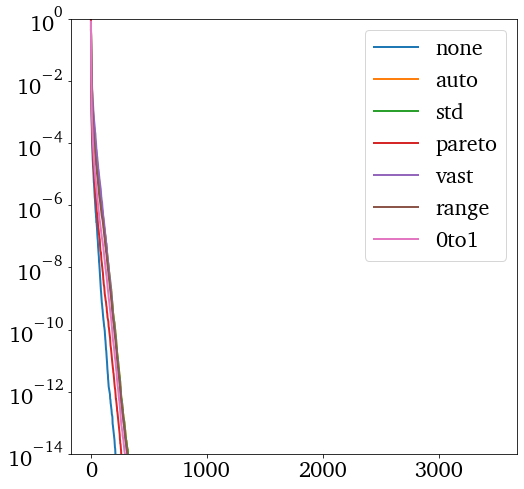

In [5]:
NPODs      = 128
ScalingVec = ['none', 'auto', 'std', 'pareto', 'vast', 'range', '0to1']
#'none', '', 'auto', 'std', 'pareto', 'vast', 'range', '0to1', '-1to1', 'level', 'max', 'poisson', 'vast_2', 'vast_3', 'vast_4'

plt.figure(figsize=(8,8))
for j, Scaling in enumerate(ScalingVec):

    pca        = PCAA(yMat, scaling=Scaling, n_components=int(NPODs))
    C          = pca.X_center
    D          = pca.X_scale
    A          = pca.A[:,0:NPODs].T
    L          = pca.L
    AT         = A.T

    plt.plot(L, label=Scaling)
    
plt.ylim([1.e-14, 1.e0])
plt.yscale('log')
plt.legend()

In [6]:
NPODsVec   = np.arange(30,150,10)
ScalingVec = ['none', 'auto', 'std', 'pareto', 'vast', 'range', '0to1']
#'none', '', 'auto', 'std', 'pareto', 'vast', 'range', '0to1', '-1to1', 'level', 'max', 'poisson', 'vast_2', 'vast_3', 'vast_4'

MaxPerc    = np.zeros((len(NPODsVec), len(ScalingVec)))
MaxSE      = np.zeros((len(NPODsVec), len(ScalingVec)))
MeanPerc   = np.zeros((len(NPODsVec), len(ScalingVec)))
MSE        = np.zeros((len(NPODsVec), len(ScalingVec)))
for i, NPODs in enumerate(NPODsVec):
    #print('NPODs = ', NPODs)
    
    for j, Scaling in enumerate(ScalingVec):

        pca        = PCAA(yMat, scaling=Scaling, n_components=int(NPODs))
        C          = pca.X_center
        D          = pca.X_scale
        A          = pca.A[:,0:NPODs].T
        L          = pca.L
        AT         = A.T

        yMat_pca   = ((yMat - C)/D).dot(AT)
        yMat_      = (yMat_pca.dot(A))*D + C
        
        MaxPerc[i,j]    = np.max(abs((yMat - yMat_)/yMat)*100)
        MaxSE[i,j]      = np.max((yMat - yMat_)**2)
        MeanPerc[i,j]   = np.mean(abs((yMat - yMat_)/yMat)*100)
        MSE[i,j]        = np.mean((yMat - yMat_)**2)

KeyboardInterrupt: 

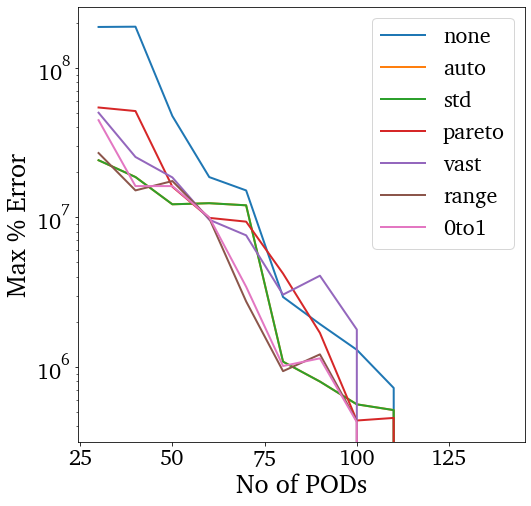

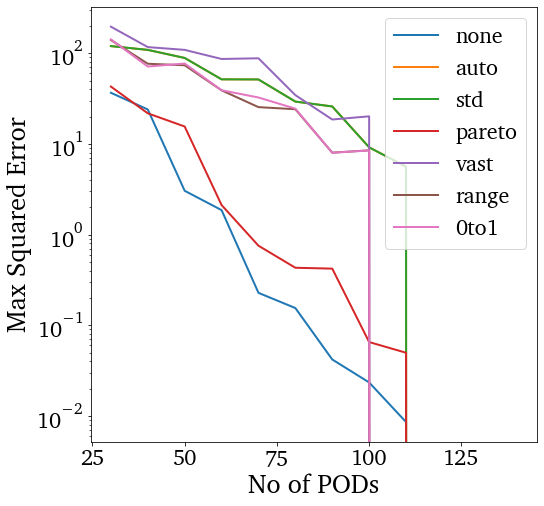

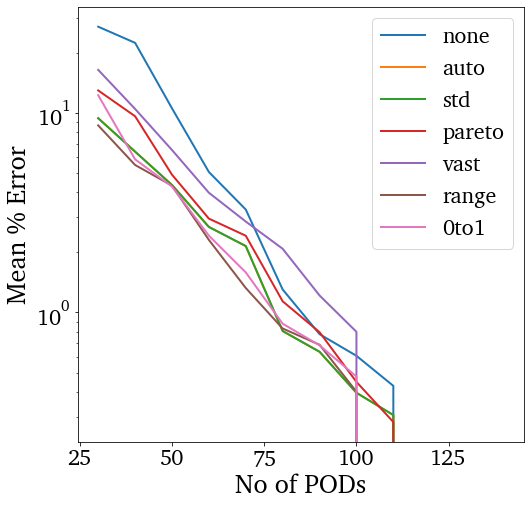

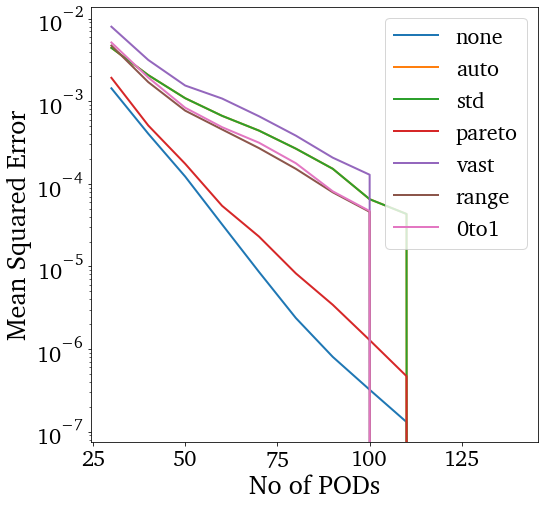

In [7]:
plt.figure(figsize=(8,8))
plt.plot(NPODsVec, MaxPerc, label=ScalingVec)
plt.xlabel('No of PODs')
plt.ylabel('Max % Error')
plt.legend()
plt.yscale('log')

plt.figure(figsize=(8,8))
plt.plot(NPODsVec, MaxSE, label=ScalingVec)
plt.xlabel('No of PODs')
plt.ylabel('Max Squared Error')
plt.legend()
plt.yscale('log')

plt.figure(figsize=(8,8))
plt.plot(NPODsVec, MeanPerc, label=ScalingVec)
plt.xlabel('No of PODs')
plt.ylabel('Mean % Error')
plt.legend()
plt.yscale('log')

plt.figure(figsize=(8,8))
plt.plot(NPODsVec, MSE, label=ScalingVec)
plt.xlabel('No of PODs')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.yscale('log')

In [84]:
NPODs      = 128

pca        = PCAA(yMat, scaling='pareto', n_components=NPODs)
C          = pca.X_center
D          = pca.X_scale
A          = pca.A[:,0:NPODs].T
L          = pca.L
AT         = A.T
print('[PCA] Shape of A        = ', A.shape)
print('[PCA] ')

[PCA] Shape of A        =  (128, 3503)
[PCA] 


In [85]:
try:
    os.makedirs(OutputDir+'/'+str(NVarsRed)+'PC/POD_'+POD_NAME+'/ROM/')
except:
    pass

FileName    = OutputDir+'/'+str(NVarsRed)+'PC/POD_'+POD_NAME+'/ROM/A.csv'
np.savetxt(FileName, A, delimiter=',')

FileName    = OutputDir+'/'+str(NVarsRed)+'PC/POD_'+POD_NAME+'/ROM/C.csv'
np.savetxt(FileName, C, delimiter=',')

FileName    = OutputDir+'/'+str(NVarsRed)+'PC/POD_'+POD_NAME+'/ROM/D.csv'
np.savetxt(FileName, D, delimiter=',')

In [86]:
#yMat_pca    = pca.transform(yMat, nocenter=False)
yMat_pca   = ((yMat - C)/D).dot(AT)

yMat_      = (yMat_pca.dot(A))*D + C
print('[PCA] Shape of yMat_pca = ', yMat_pca.shape)
print('[PCA]  Max % Error = ', np.max(abs((yMat - yMat_)/yMat)*100))
print('[PCA]  Max      SE = ', np.max((yMat - yMat_)**2))
print('[PCA] Mean % Error = ', np.mean(abs((yMat - yMat_)/yMat)*100))
print('[PCA]          MSE = ', np.mean((yMat - yMat_)**2))

[PCA] Shape of yMat_pca =  (5000, 128)
[PCA]  Max % Error =  315472.9460947904
[PCA]  Max      SE =  0.00946113918790027
[PCA] Mean % Error =  0.14692349719881853
[PCA]          MSE =  1.0702216666380348e-07


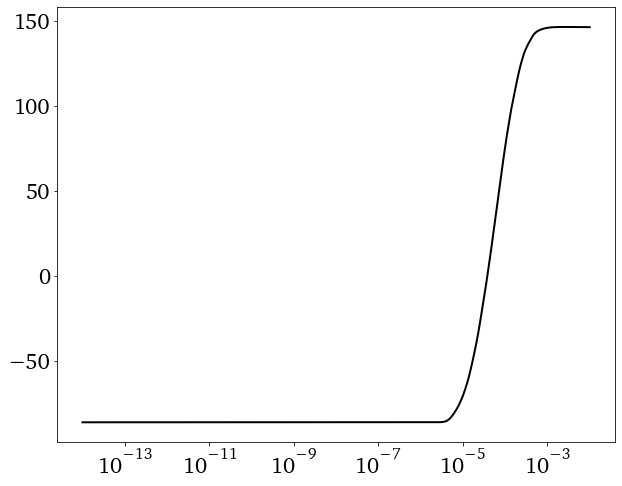

In [87]:
plt.figure(figsize=(10,8))
plt.plot(tVec, yMat_pca[:,0], '-k')
plt.xscale('log')
#plt.xlim([1.e-6,1.e-4])

(1e-06, 0.01)

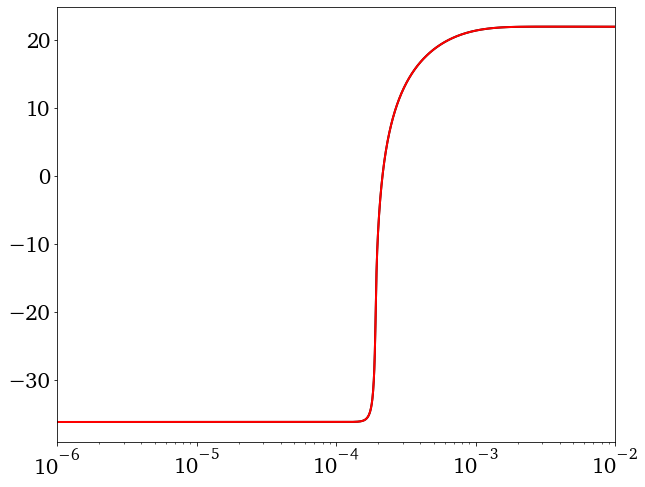

In [93]:
plt.figure(figsize=(10,8))
plt.plot(tVec, yMat[:,0], '-k')
plt.plot(tVec, yMat_[:,0], '-r')
plt.xscale('log')
plt.xlim([1.e-6,1.e-2])

In [89]:
Vars             = ['POD_'+str(iPOD+1) for iPOD in range(NPODs)]
Data             = pd.DataFrame(yMat_pca, columns=Vars)
tVec[tVec == 0.] = FixedMinVal
Data['t']        = tVec
Data['log(t)']   = np.log(tVec)
Data['log10(t)'] = np.log10(tVec)


Data

,POD_1,POD_2,POD_3,POD_4,POD_5,POD_6,POD_7,POD_8,POD_9,POD_10,...,POD_122,POD_123,POD_124,POD_125,POD_126,POD_127,POD_128,t,log(t),log10(t)
0,-85.900248,8.986741,3.833452,-1.710226,0.906600,0.569039,0.384547,0.255055,-0.202186,-0.162595,...,-0.001110,0.000413,-0.000022,0.000012,-0.000575,0.000030,-0.000513,1.000000e-14,-32.236191,-14.000000
1,-85.900248,8.986741,3.833452,-1.710226,0.906600,0.569039,0.384547,0.255055,-0.202186,-0.162595,...,-0.001110,0.000413,-0.000022,0.000012,-0.000575,0.000030,-0.000513,1.000000e-12,-27.631021,-12.000000
2,-85.900248,8.986741,3.833452,-1.710226,0.906600,0.569039,0.384547,0.255055,-0.202186,-0.162595,...,-0.001110,0.000413,-0.000022,0.000012,-0.000575,0.000030,-0.000513,1.097499e-12,-27.537987,-11.959596
3,-85.900248,8.986741,3.833452,-1.710226,0.906600,0.569039,0.384547,0.255055,-0.202186,-0.162595,...,-0.001110,0.000413,-0.000022,0.000012,-0.000575,0.000030,-0.000513,1.204504e-12,-27.444954,-11.919192
4,-85.900248,8.986741,3.833452,-1.710226,0.906600,0.569039,0.384547,0.255055,-0.202186,-0.162595,...,-0.001110,0.000413,-0.000022,0.000012,-0.000575,0.000030,-0.000513,1.321941e-12,-27.351920,-11.878788
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,146.616182,18.691022,-6.800591,-3.427064,-2.626524,1.709122,-0.988012,0.893194,0.881695,-0.848669,...,-0.000097,-0.000223,-0.001164,-0.011240,0.000083,-0.003985,-0.000097,9.887808e-03,-4.616453,-2.004900
4996,146.616018,18.691075,-6.800850,-3.427276,-2.626784,1.709385,-0.988234,0.893461,0.882029,-0.849160,...,-0.000100,-0.000229,-0.001197,-0.011551,0.000086,-0.004098,-0.000100,9.915738e-03,-4.613632,-2.003675
4997,146.615854,18.691128,-6.801109,-3.427488,-2.627043,1.709647,-0.988455,0.893727,0.882362,-0.849649,...,-0.000102,-0.000235,-0.001229,-0.011865,0.000088,-0.004211,-0.000103,9.943746e-03,-4.610811,-2.002450
4998,146.615690,18.691181,-6.801367,-3.427699,-2.627301,1.709908,-0.988675,0.893992,0.882694,-0.850137,...,-0.000105,-0.000241,-0.001263,-0.012182,0.000090,-0.004326,-0.000106,9.971833e-03,-4.607991,-2.001225


In [90]:
from sklearn.model_selection import train_test_split

try:
    os.makedirs(OutputDir+'/'+str(NVarsRed)+'PC/POD_'+POD_NAME)
except:
    pass
try:
    os.makedirs(OutputDir+'/'+str(NVarsRed)+'PC/POD_'+POD_NAME+'/train/')
except:
    pass
try:
    os.makedirs(OutputDir+'/'+str(NVarsRed)+'PC/POD_'+POD_NAME+'/valid/')
except:
    pass

In [91]:
data_id    = 'pts'

DataNoZero           = Data[Data['t'] >= FixedMinVal]
n_points             = len(DataNoZero)

idx                  = np.arange(n_points)
train_idx, valid_idx = train_test_split(idx, test_size=ValidPerc/100, random_state=42)

n_valid              = len(valid_idx)
n_train              = len(train_idx)

try:
    os.makedirs(OutputDir+'/'+str(NVarsRed)+'PC/POD_'+POD_NAME+'/train/'+data_id+'/')
except:
    pass
try:
    os.makedirs(OutputDir+'/'+str(NVarsRed)+'PC/POD_'+POD_NAME+'/valid/'+data_id+'/')
except:
    pass

DataInput  = DataNoZero[['t', 'log10(t)', 'log(t)'] + Vars]
DataInput.iloc[train_idx].to_csv(OutputDir+'/'+str(NVarsRed)+'PC/POD_'+POD_NAME+'/train/'+data_id+'/Input.csv', index=False)
DataInput.iloc[valid_idx].to_csv(OutputDir+'/'+str(NVarsRed)+'PC/POD_'+POD_NAME+'/valid/'+data_id+'/Input.csv', index=False)

DataOutput = DataNoZero[['t', 'log10(t)', 'log(t)'] + Vars]
DataOutput.iloc[train_idx].to_csv(OutputDir+'/'+str(NVarsRed)+'PC/POD_'+POD_NAME+'/train/'+data_id+'/Output.csv', index=False)
DataOutput.iloc[valid_idx].to_csv(OutputDir+'/'+str(NVarsRed)+'PC/POD_'+POD_NAME+'/valid/'+data_id+'/Output.csv', index=False)

In [92]:
DataNoZero           = Data
n_points             = len(DataNoZero)

n_test               = n_points

try:
    os.makedirs(OutputDir+'/'+str(NVarsRed)+'PC/POD_'+POD_NAME+'/test/')
except:
    pass

try:
    os.makedirs(OutputDir+'/'+str(NVarsRed)+'PC/POD_'+POD_NAME+'/test/ext/')
except:
    pass

DataInput  = DataNoZero[['t', 'log10(t)', 'log(t)'] + Vars]
DataInput.to_csv(OutputDir+'/'+str(NVarsRed)+'PC/POD_'+POD_NAME+'/test/ext/Input.csv', index=False)

DataOutput = DataNoZero[['t', 'log10(t)', 'log(t)'] + Vars]
DataOutput.to_csv(OutputDir+'/'+str(NVarsRed)+'PC/POD_'+POD_NAME+'/test/ext/Output.csv', index=False)